In [1]:
import os, sys, math, pickle, time
from zmqRemoteApi import RemoteAPIClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from random import randint as ri
from random import uniform as ru

from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.losses import Huber
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

In [11]:
path = os.getcwd() + "\\training\\training_data\\" + "2023_14_11"
file_list = os.listdir(path)
scene_files_list = [item for item in file_list if "modular02_" in item and "pkl" in item]
scene_files_list[0]

'joined_training_dataset_modular02_2023_14_11_1024.pkl'

### Funciones

In [14]:
#Function to split the training data into X,y datasets
def load_dataset(scene_in = "modular02a", date = "2023_14_11"):
    # Defining usefull variables
    path = os.getcwd() + "\\training\\training_data\\" + date
    file_list = os.listdir(path)
    scene_files_list = [item for item in file_list if scene_in in item and "pkl" in item]

    file = open(path + "\\" + scene_files_list[0], "rb")
    training_data = pickle.load(file)
    training_df = pd.DataFrame(training_data)

    #List to store the name for every joint data column
    increments_columns = []
    prev_j_positions_columns = []
    post_j_positions_columns = []

    #Creates the name for every column
    num_joints = len(training_data[-1]["increments"])
    for joint_n in range(num_joints):
        #List to split inputs per joint
        joint_inc_col_name = "increments_" + str(joint_n)
        increments_columns.append(joint_inc_col_name)

        prev_joint_pos_col_name = "prev_j_positions_" + str(joint_n)
        prev_j_positions_columns.append(prev_joint_pos_col_name)

        #List to split outputs per joint
        post_joint_pos_col_name = "post_j_positions_" + str(joint_n)
        post_j_positions_columns.append(post_joint_pos_col_name)


    #Input columns per joint
    increments_df = pd.DataFrame(training_df['increments'].to_list())
    increments_df.columns = increments_columns


    prev_j_positions_df = pd.DataFrame(training_df['prev_j_positions'].to_list())
    prev_j_positions_df.columns = prev_j_positions_columns


    #Builds the X dataframe
    X_df = pd.concat([increments_df, prev_j_positions_df, 
                    training_df["prev_pos_x"], training_df["prev_pos_y"], training_df["prev_pos_z"]], 
                    axis="columns")


    #Output columns per joint
    post_j_positions_df = pd.DataFrame(training_df['post_j_positions'].to_list())
    post_j_positions_df.columns = post_j_positions_columns


    #Builds the y dataframe
    y_df = pd.concat([post_j_positions_df, 
                    training_df["post_pos_x"], training_df["post_pos_y"], training_df["post_pos_z"]], 
                    axis="columns")

    return(X_df,y_df)

In [3]:
def adapt_X_y(X_a,y_a):
    X_a_cols = ['current_state_x', 'current_state_y', 'current_state_z', 'joint0_current_state_rad', 'joint1_current_state_rad', 'joint0_actions_rad', 'joint1_actions_rad']

    X_a = pd.concat([X_a["prev_pos_x"], X_a["prev_pos_y"] , X_a["prev_pos_z"],
                X_a["prev_j_positions_0"], X_a["prev_j_positions_1"],
                X_a["increments_0"], X_a["increments_1"]], 
                        axis="columns")

    X_a.columns = X_a_cols

    y_a_cols = ['future_state_x', 'future_state_y', 'future_state_z', 'joint0_future_state_rad', 'joint1_future_state_rad']

    y_a = pd.concat([y_a["post_pos_x"], y_a["post_pos_y"] , y_a["post_pos_z"],
                y_a["post_j_positions_0"], y_a["post_j_positions_1"]], 
                        axis="columns")
    y_a.columns = y_a_cols
    return X_a, y_a

In [18]:
def plot_history(history, loss):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel(f'{loss} Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
  plt.legend()
  plt.show()

In [5]:
def plot_pred_vs_test(test, pred):
    columns = test.columns.tolist()
    max_list = []
    min_list = []
    mse_list = []
    perc_mse_list = []
    for column_num in range(len(columns)):
        plt.figure()
        plt.scatter(test.iloc[:,column_num], pred.iloc[:,column_num], s=1)

        #Getting important values
        minim = min(test.iloc[:,column_num])
        min_list.append(minim)
        maxim = max(test.iloc[:,column_num])
        max_list.append(maxim)
        mse = mean_squared_error(test.iloc[:,column_num], pred.iloc[:,column_num])
        mse_list.append(round(mse,6))
        rang = (maxim-minim)
        perc = mse/rang *100
        perc_mse_list.append(round(perc,6))
        title = columns[column_num] + " - mse: " + str(round(mse,6))
        plt.title(title)
        plt.xlabel('True Values')
        plt.ylabel('Predictions')
        # Para tener una linea recta con la cual comparar los valores y que no altere
        # los limites de la figura se grafican los valores reales con ellos mismos
        plt.plot(test.iloc[:,column_num],test.iloc[:,column_num])
        plt.grid()
    data = {"Perception": columns, "Max.": max_list, "Min.": min_list, "Mse": mse_list, "Mse perc.": perc_mse_list}
    data_df = pd.DataFrame(data)
    return(data_df)

In [23]:
def export_model(exp_scene, exp_model, exp_scaler):
    timestr = time.strftime("_%Y_%d_%m")
    models_path = "models\\" + timestr[1:]
    if not os.path.exists(models_path):
        os.mkdir(models_path)
        print(f"Directorio '{models_path}' ha sido creado.")
    else:
        print(f"El directorio '{models_path}' ya existe.")
    exp_model.save(models_path + "\\model_" + exp_scene + timestr + ".keras")
    with open(models_path + "\\model_" + exp_scene + timestr + '.pkl', 'wb') as file:
        pickle.dump(exp_model, file)
    with open(models_path + "\\scaler_" + exp_scene + timestr + '.pkl', 'wb') as file:
        pickle.dump(exp_scaler, file)

### Modular02a

In [9]:
scene = "modular02_"
date = "2023_14_11"
X, y =load_dataset(scene, date)
X.shape

IndexError: list index out of range

In [ ]:
# Se separan los datos de entrenmiento (80%) y los de prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, random_state=42
)

X_train.shape,X_test.shape

In [ ]:
y_train.shape,y_test.shape

In [ ]:
# Scaling de los datos 
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

In [ ]:
model = Sequential()

# Capa de entrada con 22 unidades (correspondiente al número de entradas)
model.add(Dense(units=7, input_dim=7, activation='relu'))

# Capas ocultas con 64 unidades cada una
model.add(Dense(units=24, activation='relu'))

# Capa de salida con 14 unidades (correspondiente al número de salidas) y activación lineal
model.add(Dense(units=5, activation='linear'))

# Compilar el modelo con una función de pérdida adecuada para regresión
model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=1.0))

# Supongamos que X_train y y_train son tus datos de entrenamiento
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=20, validation_split=0.2)

In [ ]:
plot_history(history, "Huber")

In [ ]:
def plot_pred_vs_test(test, pred):
    columns = test.columns.tolist()
    max_list = []
    min_list = []
    mse_list = []
    perc_mse_list = []
    for column_num in range(len(columns)):
        plt.figure()
        plt.scatter(test.iloc[:,column_num], pred.iloc[:,column_num])

        #Getting important values
        minim = min(pred.iloc[:,column_num])
        min_list.append(minim)
        maxim = max(pred.iloc[:,column_num])
        max_list.append(maxim)
        mse = mean_squared_error(test.iloc[:,column_num], pred.iloc[:,column_num])
        mse_list.append(round(mse,6))
        rang = (maxim-minim)
        perc = mse/rang *100
        perc_mse_list.append(round(perc,3))
        title = columns[column_num] + " - mse: " + str(round(mse,6))
        plt.title(title)
        plt.xlabel('True Values')
        plt.ylabel('Predictions')
        # Para tener una linea recta con la cual comparar los valores y que no altere
        # los limites de la figura se grafican los valores reales con ellos mismos
        plt.plot(test.iloc[:,column_num],test.iloc[:,column_num])
        plt.grid()
    data = {"Perception": columns, "Max.": max_list, "Min.": min_list, "Mse": mse_list, "Mse perc.": perc_mse_list}
    data_df = pd.DataFrame(data)
    return(data_df)

In [ ]:
## Finalmente se hace uso de los datos de prueba para la predicción.
test_predictions = model.predict(X_test_scaled)
df_test_predictions = pd.DataFrame(test_predictions)

In [ ]:
plot_pred_vs_test(y_test, df_test_predictions)

In [ ]:
timestr = time.strftime("_%Y_%d_%m")
model_name = "model_" + scene + timestr + ".keras"
print(model_name)
model.save("models\\" + model_name)

### Modular 02

In [13]:
scene = "modular02_"
date = "2023_14_11"
X, y =load_dataset(scene, date)
X, y = adapt_X_y(X,y)
X

['joined_training_dataset_modular02_2023_14_11_1024.pkl']


,current_state_x,current_state_y,current_state_z,joint0_current_state_rad,joint1_current_state_rad,joint0_actions_rad,joint1_actions_rad
0,0.085313,0.000005,0.156858,-0.785398,-0.785398,-0.035228,0.008034
1,0.087355,0.000001,0.154454,-0.820785,-0.777326,-0.122511,0.072272
2,0.093529,-0.000013,0.145499,-0.943990,-0.704675,-0.112824,-0.119296
3,0.097128,0.000022,0.131159,-1.057933,-0.824201,-0.096348,-0.091552
4,0.098422,0.000007,0.119065,-1.155711,-0.916394,0.128615,-0.019378
...,...,...,...,...,...,...,...
34995,0.097520,-0.000264,0.090918,-1.348545,-1.462710,0.108797,0.031302
34996,0.099184,-0.000264,0.100637,-1.240552,-1.431434,-0.062875,0.121708
34997,0.102269,-0.000262,0.096705,-1.304426,-1.309168,-0.030965,-0.026722
34998,0.101416,-0.000263,0.093457,-1.336431,-1.335516,-0.059305,-0.127545


In [15]:
# Se separan los datos de entrenmiento (80%) y los de prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, random_state=42
)

X_train.shape, y_train.shape

((28000, 7), (28000, 5))

In [16]:
# Scaling de los datos 
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled.shape

(28000, 7)

In [17]:
# Creacion y entrenamiento del modelo
model = Sequential()

# Capa de entrada con 22 unidades (correspondiente al número de entradas)
model.add(Dense(units=7, input_dim=7, activation='relu'))

# Capas ocultas con 64 unidades cada una
model.add(Dense(units=24, activation='relu'))

# Capa de salida con 14 unidades (correspondiente al número de salidas) y activación lineal
model.add(Dense(units=5, activation='linear'))

# Compilar el modelo con una función de pérdida adecuada para regresión
model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=1.0))

# Supongamos que X_train y y_train son tus datos de entrenamiento
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=20, validation_split=0.2)

Epoch 1/50
1120/1120 [==============================] - 5s 3ms/step - loss: 0.0296 - val_loss: 7.5641e-04
Epoch 2/50
1120/1120 [==============================] - 3s 3ms/step - loss: 3.5278e-04 - val_loss: 1.8013e-04
Epoch 3/50
1120/1120 [==============================] - 3s 3ms/step - loss: 1.5243e-04 - val_loss: 1.1990e-04
Epoch 4/50
1120/1120 [==============================] - 3s 3ms/step - loss: 1.1545e-04 - val_loss: 1.0905e-04
Epoch 5/50
1120/1120 [==============================] - 3s 3ms/step - loss: 9.3892e-05 - val_loss: 7.9883e-05
Epoch 6/50
1120/1120 [==============================] - 3s 3ms/step - loss: 7.9390e-05 - val_loss: 7.2482e-05
Epoch 7/50
1120/1120 [==============================] - 3s 3ms/step - loss: 6.7856e-05 - val_loss: 5.7759e-05
Epoch 8/50
1120/1120 [==============================] - 3s 3ms/step - loss: 6.0035e-05 - val_loss: 6.7804e-05
Epoch 9/50
1120/1120 [==============================] - 3s 3ms/step - loss: 5.4736e-05 - val_loss: 4.8396e-05
Epoch 10/50
11

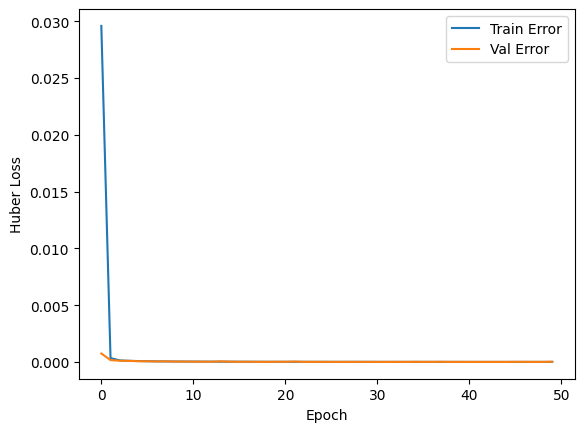

In [19]:
plot_history(history, "Huber")

In [20]:
## Finalmente se hace uso de los datos de prueba para la predicción.
test_predictions = model.predict(X_test_scaled)
df_test_predictions = pd.DataFrame(test_predictions)

219/219 [==============================] - 1s 2ms/step


In [21]:
# Pone el mismo nombre a las columnas de las predicciones a las salidas
df_test_predictions.columns = y_test.columns

,Perception,Max.,Min.,Mse,Mse perc.
0,future_state_x,0.117308,-0.119342,0.000007,0.003001
1,future_state_y,0.000727,-0.000541,0.000000,0.017773
2,future_state_z,0.210299,0.071965,0.000015,0.010890
3,joint0_future_state_rad,1.570798,-1.570798,0.000031,0.000999
4,joint1_future_state_rad,1.570797,-1.570797,0.000321,0.010208


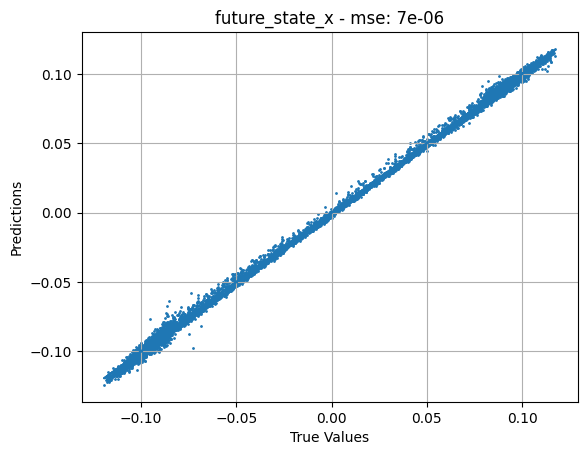

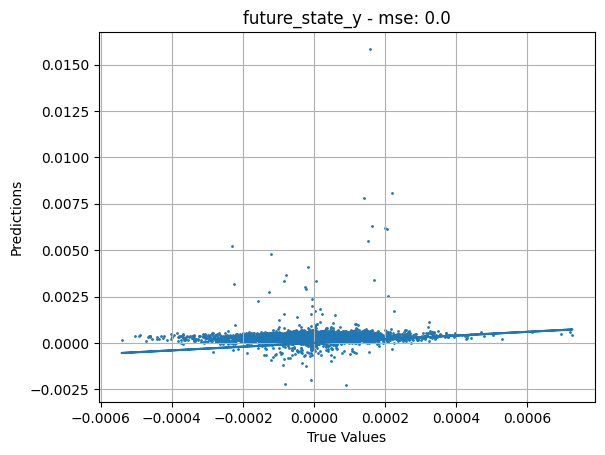

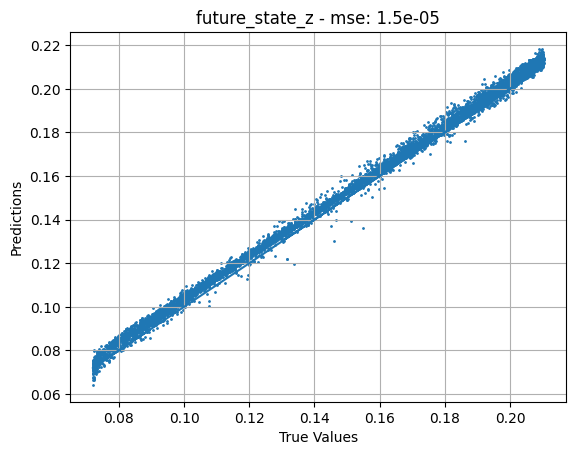

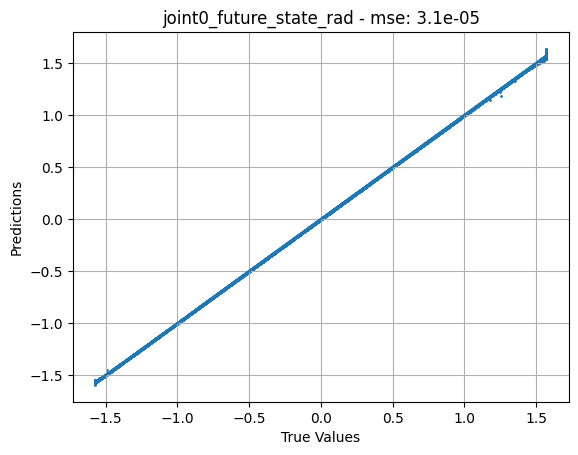

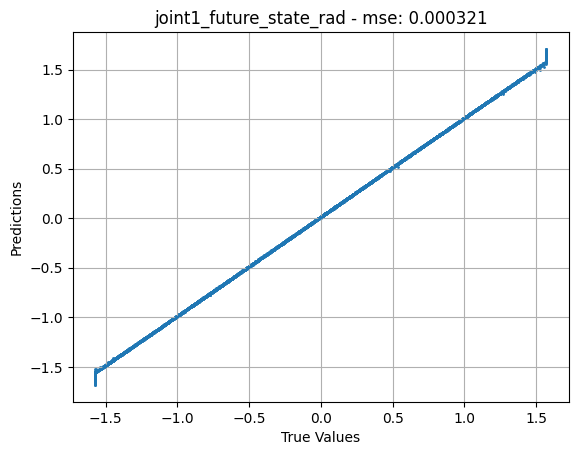

In [22]:
plot_pred_vs_test(y_test, df_test_predictions)

In [24]:
export_model(scene, model, scaler)

Directorio 'models\2023_24_11' ha sido creado.


### Datos de entrenamiento

In [10]:
scene = "modular02_"
path = os.getcwd() + "\\training_data\\2023_14_11"
file_list = os.listdir(path)
scene_files_list = [item for item in file_list if scene in item and "pkl" in item]

print(scene_files_list[0])

file = open(path + "\\" + scene_files_list[0], "rb")
training_data = pickle.load(file)
training_df = pd.DataFrame(training_data)

joined_training_dataset_modular02_2023_14_11_1024.pkl


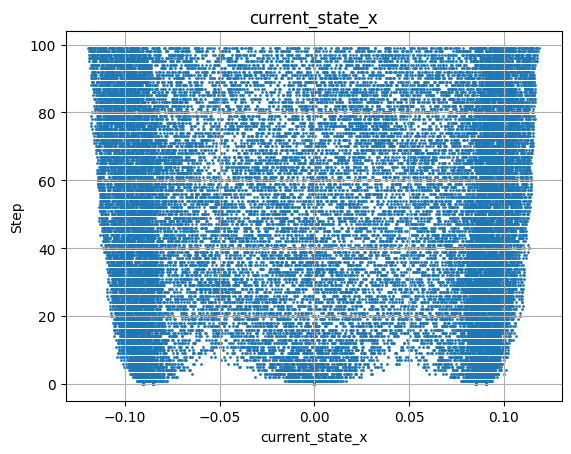

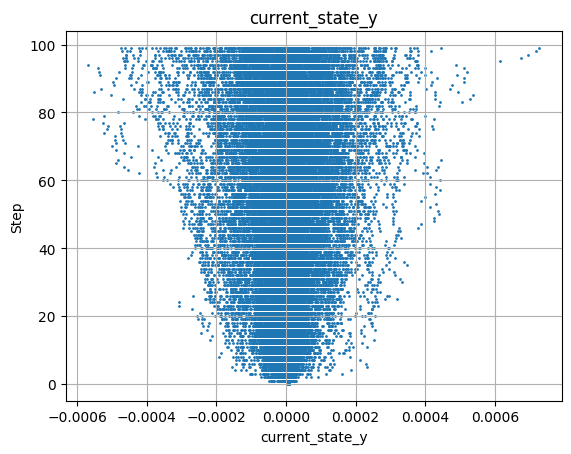

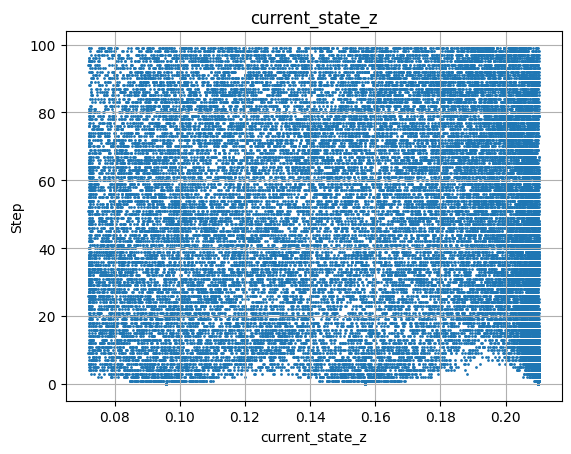

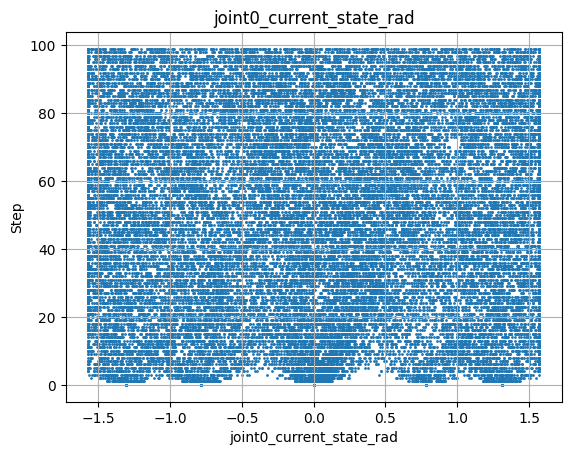

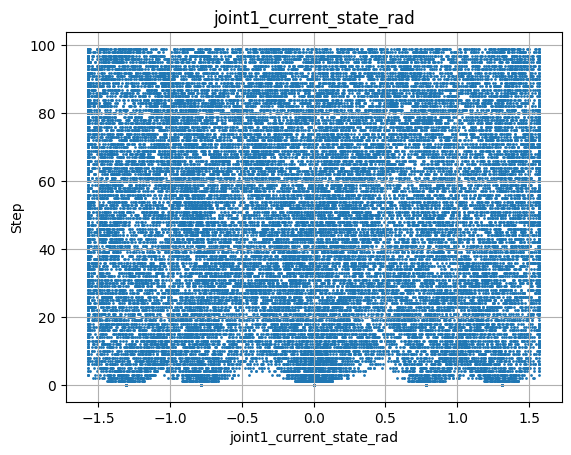

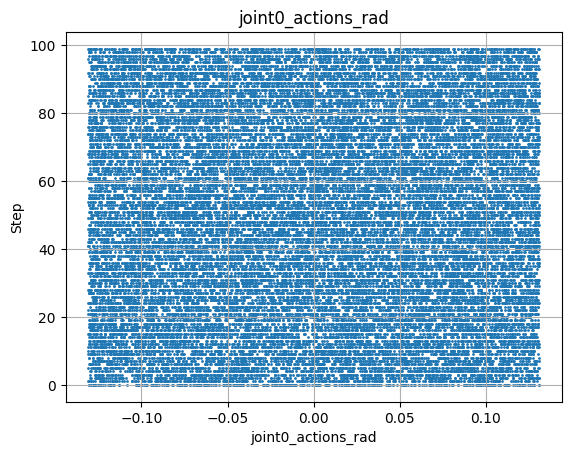

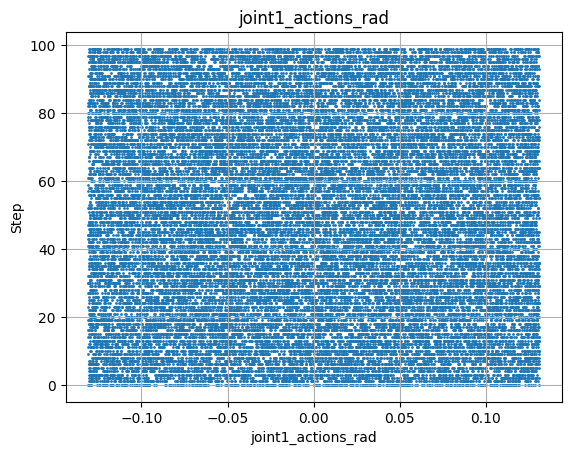

In [11]:
## Se grafica la tabla de valores de entrenamiento para ver que tanto varian y si se tiene el rango necesario para la base.
columns = X_train.columns.tolist()
for col in range(-7,0):
    plt.figure()
    plt.scatter(X.iloc[:,col],training_df.iloc[:,1], s=1)
    plt.title(columns[col])
    plt.ylabel('Step')
    plt.xlabel(columns[col])
    #plt.xlim(-1,1)
    plt.grid()

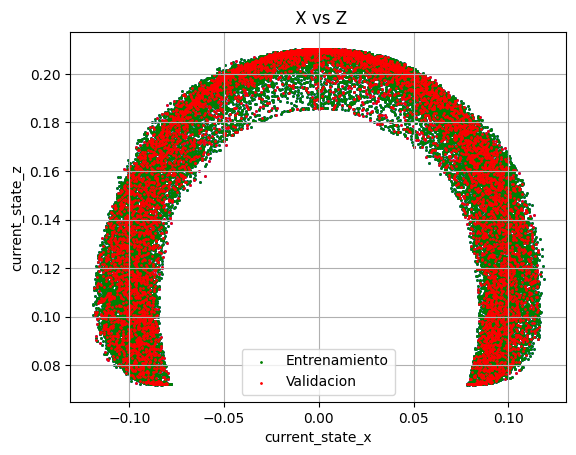

In [12]:
columns = X_train.columns.tolist()
plt.figure()
plt.scatter(X.iloc[:,-7],X.iloc[:,-5], s=1, color='blue')
plt.scatter(X_train.iloc[:,-7],X_train.iloc[:,-5], s=1, color='green', label='Entrenamiento')
plt.scatter(X_test.iloc[:,-7],X_test.iloc[:,-5], s=1, color='red', label='Validacion')
plt.title(" X vs Z")
plt.ylabel(columns[-5])
plt.xlabel(columns[-7])
plt.legend()
plt.grid()

In [16]:
#X
print(min(X_train.iloc[:,-7]),max(X_train.iloc[:,-7]))

-0.119341641664505 0.11861033737659454


In [17]:
#Z
print(min(X_train.iloc[:,-5]),max(X_train.iloc[:,-5]))

0.07191088050603867 0.21029877662658691


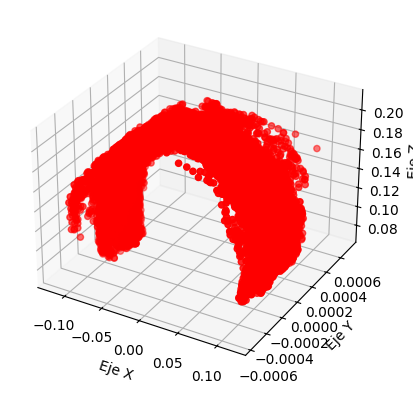

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Datos de ejemplo
x = X_train.iloc[:,-7]
y = X_train.iloc[:,-6]
z = X_train.iloc[:,-5]

# Crear una figura en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Graficar puntos en 3D
ax.scatter(x, y, z, c='r', marker='o')

# Etiquetas de ejes
ax.set_xlabel('Eje X')
ax.set_ylabel('Eje Y')
ax.set_zlabel('Eje Z')

# Mostrar la gráfica en 3D
plt.show()

Se grafica para cada posicion del joint las acciones

In [118]:
X_train.columns.tolist()

['current_state_x',
 'current_state_y',
 'current_state_z',
 'joint0_current_state_rad',
 'joint1_current_state_rad',
 'joint0_actions_rad',
 'joint1_actions_rad']

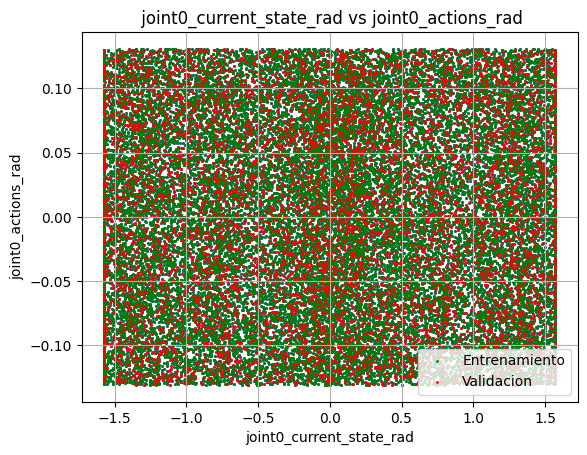

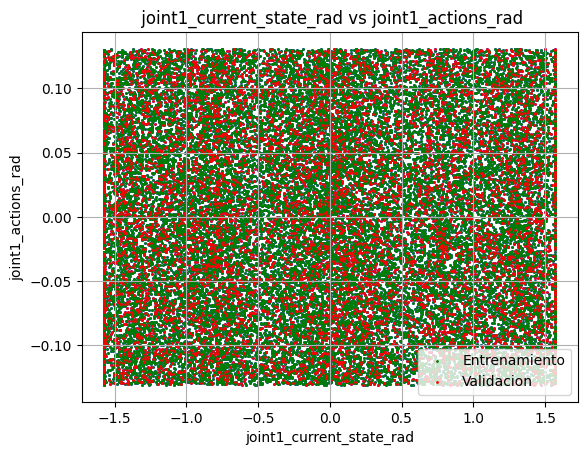

In [140]:
columns = X_train.columns.tolist()
joints_col = []
for col in columns:
    if "joint" in col:
        joints_col.append(col)
joints_col
joints_n = len(joints_col)//2
for joint in range(joints_n):
    plt.figure()
    state_col = 3 + joint
    act_col = 3 + joint + joints_n
    plt.scatter(X.iloc[:,state_col],X.iloc[:,act_col], s=1, color='blue')
    plt.scatter(X_train.iloc[:,state_col],X_train.iloc[:,act_col], s=1, color='green', label='Entrenamiento')
    plt.scatter(X_test.iloc[:,state_col],X_test.iloc[:,act_col], s=1, color='red', label='Validacion')
    plt.title(f" {columns[state_col]} vs {columns[act_col]}")
    plt.ylabel(columns[act_col])
    plt.xlabel(columns[state_col])
    plt.legend()
    plt.grid()

### Pruebas con los modelos entrenados

In [22]:
### Import the World Model and the Scaler ###################################################################
# Load the saved model
WorldModel = load_model('C:\\Users\\carlo\\OneDrive\\Imágenes\\Documentos\\GitHub\\EMERGE\\Morphology\\Multimodular\\models\\2023_14_11\\model_modular02__2023_14_11.keras')

# Load the scaler object using pickle
with open('C:\\Users\\carlo\\OneDrive\\Imágenes\\Documentos\\GitHub\\EMERGE\\Morphology\\Multimodular\\models\\2023_14_11\\scaler_modular02__2023_14_11.pkl', 'rb') as file:
    scaler = pickle.load(file)

In [23]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
## Finalmente se hace uso de los datos de prueba para la predicción.
test_predictions = WorldModel.predict(X_test_scaled)
df_test_predictions = pd.DataFrame(test_predictions)

219/219 [==============================] - 0s 801us/step


In [34]:
# Pone el mismo nombre a las columnas de las predicciones a las salidas
df_test_predictions.columns = y_test.columns

In [56]:
df_test_predictions

,future_state_x,future_state_y,future_state_z,joint0_future_state_rad,joint1_future_state_rad
0,0.078140,0.000385,0.125163,-0.880488,-1.492788
1,0.095357,0.001003,0.158847,-0.843812,-0.672858
2,0.038788,-0.000749,0.200134,-0.469608,0.330228
3,-0.011961,-0.000576,0.211690,0.081754,-0.063778
4,0.087519,0.000695,0.107388,-1.145824,-1.298111
...,...,...,...,...,...
6995,-0.094446,0.000810,0.095556,1.361745,1.556034
6996,0.094410,-0.000122,0.126974,-1.026122,-1.132360
6997,0.084961,0.000817,0.099854,-1.210474,-1.382127
6998,0.079670,0.000585,0.178699,-0.584525,-0.743100


In [57]:
maxim = max(df_test_predictions.iloc[:,-1])
max_i = df_test_predictions["joint1_future_state_rad"].tolist().index(maxim)
prev_max = X_test.iloc[max_i]["joint1_current_state_rad"]
act_max = X_test.iloc[max_i]["joint1_actions_rad"]

minim = min(df_test_predictions.iloc[:,-1])
min_i = df_test_predictions["joint1_future_state_rad"].tolist().index(minim)
prev_min = X_test.iloc[min_i]["joint1_current_state_rad"]
act_min = X_test.iloc[min_i]["joint1_actions_rad"]


print(f"Indice {max_i} valor maximo {maxim*180/math.pi} grad y {maxim} rad, estado previo {prev_max*180/math.pi} y accion {act_max*180/math.pi}")
print(f"Indice {min_i} valor minimo {minim*180/math.pi} grad y {minim} rad, estado previo {prev_min*180/math.pi} y accion {act_min*180/math.pi}")

Indice 3083 valor maximo 97.0295853869311 grad y 1.6934857368469238 rad, estado previo 90.00002299504568 y accion 7.478779785823646
Indice 2735 valor minimo -94.49927350700818 grad y -1.6493234634399414 rad, estado previo -90.00005031580235 y accion -7.4306702652188354


In [35]:
df_test_predictions.iloc[max_i]

future_state_x            -0.084351
future_state_y             0.001422
future_state_z             0.078894
joint0_future_state_rad    1.520526
joint1_future_state_rad    1.693486
Name: 3083, dtype: float32

In [86]:
x_pred = []
z_pred = []
x_test = []
z_test = []

In [87]:
j_max_x_pred = df_test_predictions.iloc[max_i]["future_state_x"]
j_max_y_pred = df_test_predictions.iloc[max_i]["future_state_y"]
j_max_z_pred = df_test_predictions.iloc[max_i]["future_state_z"]
x_pred.append(j_max_x_pred)
z_pred.append(j_max_z_pred)

j_max_x_test = y_test.iloc[max_i]["future_state_x"]
j_max_y_test = y_test.iloc[max_i]["future_state_y"]
j_max_z_test = y_test.iloc[max_i]["future_state_z"]
x_test.append(j_max_x_test)
z_test.append(j_max_z_test)

x_err = abs(j_max_x_pred-j_max_x_test)/j_max_x_test*100
y_err = abs(j_max_y_pred-j_max_y_test)
z_err = abs(j_max_z_pred-j_max_z_test)/j_max_z_test*100
print(f"El punto pred es {j_max_x_pred}, {j_max_y_pred} y {j_max_z_pred}")
print(f"El punto real es {j_max_x_test}, {j_max_y_test} y {j_max_z_test}")
print(f"El error en x {x_err} y z {z_err}")

El punto pred es -0.08435114473104477, 0.001421965891495347 y 0.0788937658071518
El punto real es -0.08129645138978958, -5.654505002894439e-06 y 0.07539542019367218
El error en x -3.757474390375226 y z 4.639997501828665


In [72]:
maxim0 = max(df_test_predictions.iloc[:,-2])
max_i0 = df_test_predictions["joint0_future_state_rad"].tolist().index(maxim0)
prev_max0 = X_test.iloc[max_i0]["joint0_current_state_rad"]
act_max0 = X_test.iloc[max_i0]["joint0_actions_rad"]

minim0 = min(df_test_predictions.iloc[:,-2])
min_i0 = df_test_predictions["joint0_future_state_rad"].tolist().index(minim0)
prev_min0 = X_test.iloc[min_i0]["joint0_current_state_rad"]
act_min0 = X_test.iloc[min_i0]["joint0_actions_rad"]


print(f"Indice {max_i0} valor maximo {maxim0*180/math.pi} grad y {maxim0} rad, estado previo {prev_max0*180/math.pi} y accion {act_max0*180/math.pi}")
print(f"Indice {min_i0} valor minimo {minim0*180/math.pi} grad y {minim0} rad, estado previo {prev_min0*180/math.pi} y accion {act_min0*180/math.pi}")

Indice 4007 valor maximo 95.52592607134196 grad y 1.6672419309616089 rad, estado previo 90.00002299504568 y accion 7.190215892479228
Indice 6542 valor minimo -93.75679096309277 grad y -1.6363646984100342 rad, estado previo -90.00005031580235 y accion -7.318696291641505


In [88]:
j_min_x_pred = df_test_predictions.iloc[min_i]["future_state_x"]
j_min_y_pred = df_test_predictions.iloc[min_i]["future_state_y"]
j_min_z_pred = df_test_predictions.iloc[min_i]["future_state_z"]
x_pred.append(j_min_x_pred)
z_pred.append(j_min_z_pred)

j_min_x_test = y_test.iloc[min_i]["future_state_x"]
j_min_y_test = y_test.iloc[min_i]["future_state_y"]
j_min_z_test = y_test.iloc[min_i]["future_state_z"]
x_test.append(j_min_x_test)
z_test.append(j_min_z_test)

x_err_min = abs(j_min_x_pred-j_min_x_test)/j_min_x_test*100
y_err_min = abs(j_min_y_pred-j_min_y_test)
z_err_min = abs(j_min_z_pred-j_min_z_test)/j_min_z_test*100
print(f"El punto pred es {j_min_x_pred}, {j_min_y_pred} y {j_min_z_pred}")
print(f"El punto real es {j_min_x_test}, {j_min_y_test} y {j_min_z_test}")
print(f"El error en x {x_err_min} y z {z_err_min}")

El punto pred es 0.03937337175011635, -0.005526425316929817 y 0.17631171643733978
El punto real es 0.05422733724117279, -0.00012624016380868852 y 0.17185717821121216
El error en x 27.39202447834444 y z 2.5920000971114545


In [90]:
x_test

[-0.08129645138978958, 0.05422733724117279]

In [91]:
z_test

[0.07539542019367218, 0.17185717821121216]

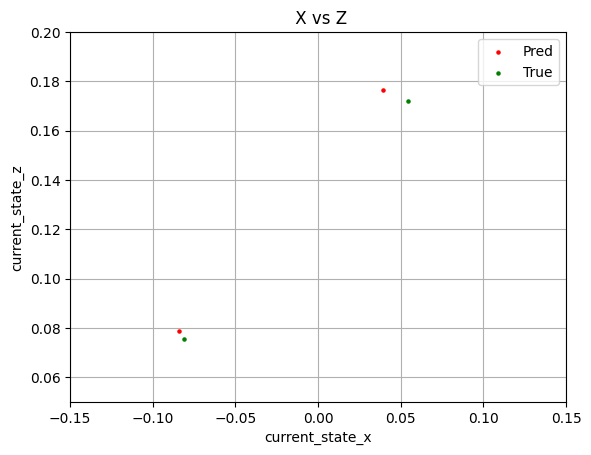

In [89]:
columns = X_train.columns.tolist()
plt.figure()
plt.scatter(x_pred,z_pred, s=5, color='red', label='Pred')
plt.scatter(x_test,z_test, s=5, color='green', label='True')
plt.title(" X vs Z")
plt.xlim(-0.15,0.15)
plt.ylim(0.05,0.2)
plt.ylabel(columns[-5])
plt.xlabel(columns[-7])
plt.legend()
plt.grid()

In [99]:
WorldModel = load_model('C:\\Users\\carlo\\OneDrive\\Imágenes\\Documentos\\GitHub\\EMERGE\\Morphology\\Multimodular\\models\\2023_14_11\\model_modular02__2023_14_11.keras')

219/219 [==============================] - 0s 818us/step


,Perception,Max.,Min.,Mse,Mse perc.
0,future_state_x,0.117308,-0.119342,0.000018,0.007718
1,future_state_y,0.000727,-0.000541,0.000002,0.146693
2,future_state_z,0.210299,0.071965,0.000029,0.020849
3,joint0_future_state_rad,1.570798,-1.570798,0.000068,0.002150
4,joint1_future_state_rad,1.570797,-1.570797,0.000093,0.002947


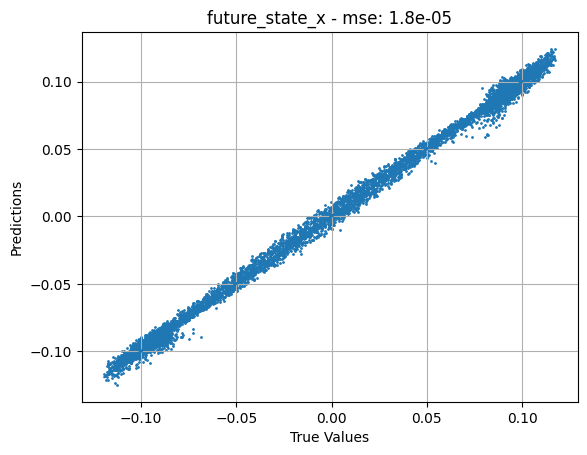

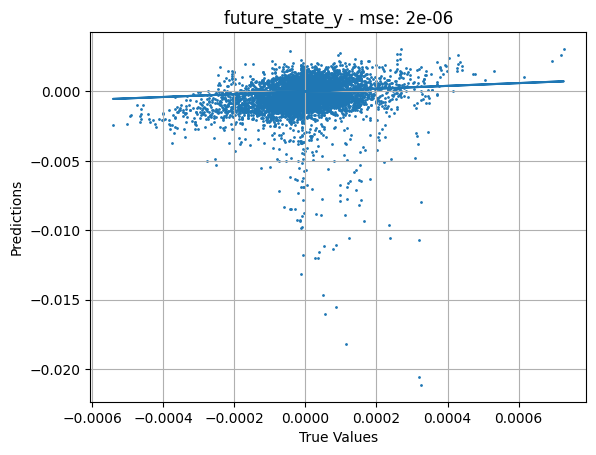

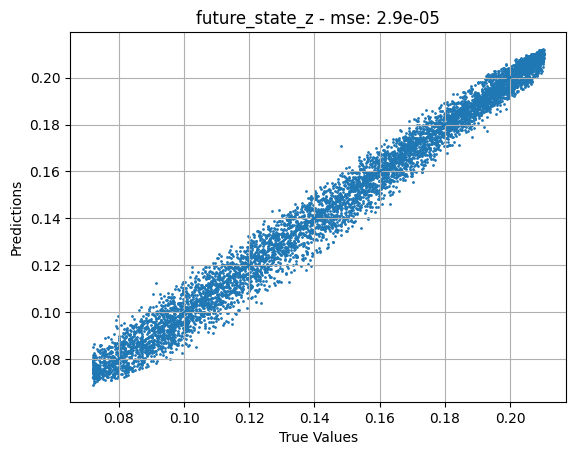

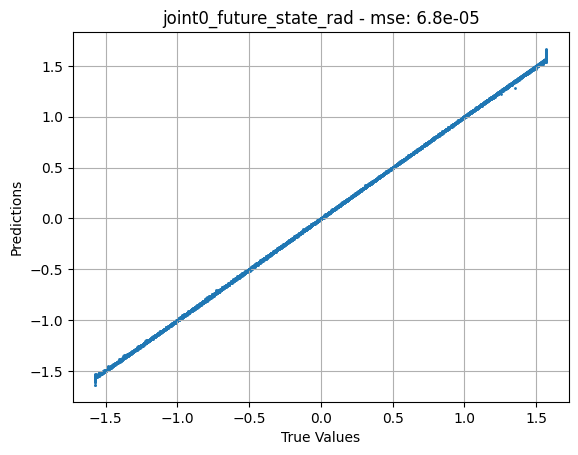

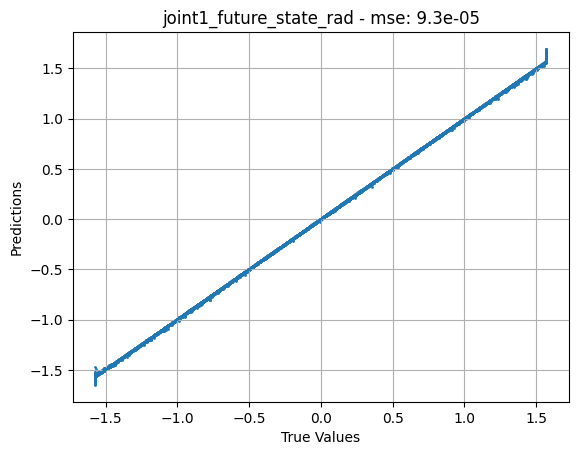

In [100]:
## Finalmente se hace uso de los datos de prueba para la predicción.
test_predictions = WorldModel.predict(X_test_scaled)
df_test_predictions = pd.DataFrame(test_predictions)
plot_pred_vs_test(y_test, df_test_predictions)

### Fin